Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
pytorch==1.9.0_cuda11.1
fastai==2.5.2
tifffile==2020.9.3
opencv-python==4.5.3.56
efficientnet-pytorch==0.7.1
tqdm==4.47.0

# EfficientNetB0 Pretraining

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Data allocation (Mouse #)
TRAIN = [1,2,3]
VALID = [4]
TEST = [5]

In [3]:
TRAIN = f'[{TRAIN[0]}{TRAIN[1]}{TRAIN[2]}]'
VALID = VALID[0]
TEST = TEST[0]

In [4]:
print(TRAIN)
print(VALID)
print(TEST)

[123]
4
5


# Training

In [5]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [6]:
# Random seed
import os, random
SEED = 2021

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms = True
    torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(SEED)
generator = torch.Generator()
generator.manual_seed(SEED)

In [7]:
BATCH_SIZE = 128 #512
VER = 'b0'
from efficientnet_pytorch import EfficientNet
cnn = EfficientNet.from_pretrained('efficientnet-'+VER, num_classes=1)

Loaded pretrained weights for efficientnet-b0


In [8]:
# Model
model = cnn.cuda()

In [9]:
# Count number of parameters
params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
print(params) 

4008829


In [10]:
df = pd.read_csv('./data_64_5mice.csv')
df

,Data_ID,Mouse_#
0,20180125_Emx1G6_LR_1,1
1,20180125_Emx1G6_R_1,3
2,20180125_Emx1G6_non_1,2
3,20180126_Emx1G6_LR_1,1
4,20180126_Emx1G6_R_1,3
...,...,...
59,20180411_Emx1G6_non_1,5
60,20180412_Emx1G6_L_1,4
61,20180412_Emx1G6_non_1,5
62,20180413_Emx1G6_L_1,4


In [11]:
# parameter fof normalizing
mean_dict = {}
std_dict = {}
save_path = './mean_and_std/'

for i in df['Data_ID']:
    m = np.load(save_path + i + '_mean.npy')
    s = np.load(save_path + i + '_std.npy')
    mean_dict[i] = m
    std_dict[i] = s

In [12]:
import glob
import re

In [13]:
# Dataset
class ImageLoadDataset:
    def __init__(self, file_names):
        self.files = file_names
        
    def __len__(self):
        return (len(self.files))
    
    def __getitem__(self, idx):
        npz_path = self.files[idx]
        xy_data = np.load(npz_path)
        experiment_name = npz_path[len('./npz_data/1/'):-len(re.search('_\d+.npz',npz_path).group())] # Data_ID
        mean = mean_dict[experiment_name]
        std = std_dict[experiment_name]
        x_tmp = (xy_data['image'] - mean) / std # Normalize
        x = torch.tensor(x_tmp, dtype=torch.float)
        y = torch.tensor(xy_data['label'], dtype=torch.float)            
        return x, y

In [14]:
# Dataset setting
from fastai.data.core import DataLoaders
ds_train = ImageLoadDataset(glob.glob(f'./npz_data/{TRAIN}/*.npz'))
ds_valid = ImageLoadDataset(glob.glob(f'./npz_data/{VALID}/*.npz'))
dls = DataLoaders.from_dsets(ds_train, ds_valid, bs=BATCH_SIZE, shuffle=True,
        num_workers=10, pin_memory=True, worker_init_fn=seed_worker, generator=generator).cuda()

In [15]:
# Learn setting
from fastai.vision.all import Learner, ShowGraphCallback, SaveModelCallback
loss = nn.BCEWithLogitsLoss()
learn = Learner(dls, model, loss_func=loss)
callbacks = [SaveModelCallback(monitor='valid_loss', comp=np.less), ShowGraphCallback()]

epoch,train_loss,valid_loss,time
0,0.114189,0.355149,10:03
1,0.065035,0.386564,10:01


Better model found at epoch 0 with valid_loss value: 0.355148583650589.


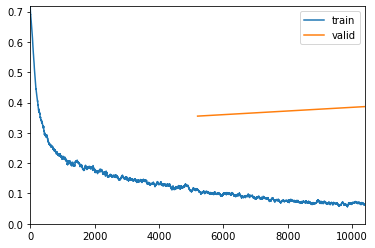

In [16]:
# Training
Epoch = 2
learn.fit_one_cycle(Epoch, lr_max=1e-3, cbs=callbacks)

In [17]:
# Save model
torch.save(learn.model.state_dict(),f'./stage1_model/model_EfficientNet{VER}_valid{VALID}_test{TEST}.pth')

# Inference

In [18]:
# Load model
learn.model.load_state_dict(torch.load(f'./stage1_model/model_EfficientNet{VER}_valid{VALID}_test{TEST}.pth'))

<All keys matched successfully>

In [19]:
from tqdm.auto import tqdm
import gc

def inference_1_image(file_path):
    Y_pred = np.zeros([len(file_path), 1])
    Y_true = np.zeros([len(file_path), 1])
    ds_i = ImageLoadDataset(file_path)
    infe = DataLoader(ds_i, batch_size=BATCH_SIZE, shuffle=False, num_workers=10, pin_memory=True)
    tqdm_loader = tqdm(infe)
    for idx, (imgs,labels) in enumerate(tqdm_loader):
        bs = labels.shape[0]
        Y_pred[idx*BATCH_SIZE:idx*BATCH_SIZE+bs] = torch.sigmoid(learn.model(imgs.cuda())).cpu().detach().numpy()
        Y_true[idx*BATCH_SIZE:idx*BATCH_SIZE+bs] = labels
    del ds_i, infe, tqdm_loader
    gc.collect();
    return Y_pred, Y_true

In [20]:
test_folder = glob.glob(f'./npz_data/{TEST}/*_0.npz')
exp_path = [test_folder[i].rstrip('_0.npz') for i in range(len(test_folder))]
print(exp_path)

['./npz_data/5/20180326_Emx1G6_non_1', './npz_data/5/20180405_Emx1G6_non_1', './npz_data/5/20180327_Emx1G6_non_1', './npz_data/5/20180412_Emx1G6_non_1', './npz_data/5/20180328_Emx1G6_non_1', './npz_data/5/20180409_Emx1G6_non_1', './npz_data/5/20180406_Emx1G6_non_1', './npz_data/5/20180323_Emx1G6_non_1', './npz_data/5/20180321_Emx1G6_non_1', './npz_data/5/20180403_Emx1G6_non_1', './npz_data/5/20180413_Emx1G6_non_1', './npz_data/5/20180411_Emx1G6_non_1']


In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

def calculate_accuracy(exp_paths):
    Y_pred_all = []
    Y_true_all = []
    acc = np.zeros(len(exp_paths))
    for i, exp_path in enumerate(exp_paths):
        print(exp_path)
        files = glob.glob(exp_path + '*.npz')
        print(f'frame number: {len(files)}')
        Y_pred, Y_true = inference_1_image([exp_path + f'_{i}.npz' for i in range(len(files))])
        Y_pred_all.append(Y_pred)
        Y_true_all.append(Y_true)
        output = Y_pred > 0.5
        accuracy = (output == Y_true).mean()
        print('Accuracy: {}'.format(accuracy))
        AUC = roc_auc_score(Y_true, Y_pred)
        print(f'AUC: {AUC}')
        acc[i] = accuracy
    print('Mean Accuracy: {}'.format(acc.mean()))
    return Y_pred_all, Y_true_all

In [22]:
Y_pred, Y_true = calculate_accuracy(exp_path)

./npz_data/5/20180326_Emx1G6_non_1
frame number: 17998



Accuracy: 0.8491499055450605
AUC: 0.8920750550573798
./npz_data/5/20180405_Emx1G6_non_1
frame number: 17998



Accuracy: 0.8735970663407046
AUC: 0.8953603019237037
./npz_data/5/20180327_Emx1G6_non_1
frame number: 17998



Accuracy: 0.746249583287032
AUC: 0.9518168073767403
./npz_data/5/20180412_Emx1G6_non_1
frame number: 17998



Accuracy: 0.7995332814757196
AUC: 0.913023337518744
./npz_data/5/20180328_Emx1G6_non_1
frame number: 17998



Accuracy: 0.8597066340704522
AUC: 0.9103873696715554
./npz_data/5/20180409_Emx1G6_non_1
frame number: 17998



Accuracy: 0.8483720413379264
AUC: 0.9500969953803411
./npz_data/5/20180406_Emx1G6_non_1
frame number: 17998



Accuracy: 0.9018779864429382
AUC: 0.9543700393178373
./npz_data/5/20180323_Emx1G6_non_1
frame number: 17998



Accuracy: 0.8668185353928214
AUC: 0.713318185356081
./npz_data/5/20180321_Emx1G6_non_1
frame number: 17998



Accuracy: 0.8128680964551617
AUC: 0.951502505599964
./npz_data/5/20180403_Emx1G6_non_1
frame number: 17998



Accuracy: 0.8139793310367819
AUC: 0.9483907517852898
./npz_data/5/20180413_Emx1G6_non_1
frame number: 17998



Accuracy: 0.8802644738304256
AUC: 0.9588856345214494
./npz_data/5/20180411_Emx1G6_non_1
frame number: 17998



Accuracy: 0.7628069785531726
AUC: 0.8532108914282279
Mean Accuracy: 0.8346019928140165


In [23]:
# Save test result
from scipy import io
io.savemat(f"./result/test_result_EfficientNet{VER}_valid{VALID}_test{TEST}.mat", {"test_label":Y_true, "test_pred":Y_pred})

In [24]:
# Plot ROC curve
def plot_roc(y_pred, y_test, mode):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    AUC = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
    plt.title(mode + " ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    print('AUC: {:.3f}'.format(AUC))
    opt_thr = thresholds[np.argmax(tpr - fpr)]
    print('Optimal threshold: {:.3f}'.format(opt_thr))

In [25]:
test_pred = np.vstack(Y_pred)
test_true = np.vstack(Y_true)

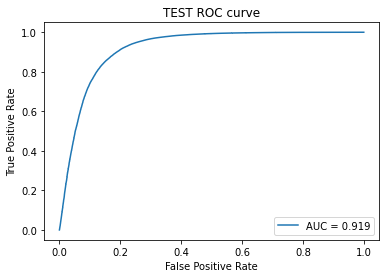

AUC: 0.919
Optimal threshold: 0.300


In [26]:
plot_roc(test_pred, test_true, "TEST")